In [13]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [14]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2

import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [15]:
train_dir = 'data/512/train/'
test_dir = 'data/512/test/'
test_dir_whithout_aug = "data/512/test-without-aug/"

extracted_features_dir = "extracted_features/"
model_name = "BottleNeck1"

In [16]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [33]:
output_classes = 4
batch_size = 1
img_height, img_width = 512, 512
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
nb_test_samples = sum([len(files) for r, d, files in os.walk(test_dir)])
nb_test_without_aug_samples = sum([len(files) for r, d, files in os.walk(test_dir_whithout_aug)])

print("train samples:", nb_train_samples)
print("test samples:", nb_test_samples)
print("test without aug samples:", nb_test_without_aug_samples)

train samples: 4608
test samples: 1792
test without aug samples: 112


In [34]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir_whithout_aug):
    print (root, len(files))

data/512/train/ 0
data/512/train/Benign 1152
data/512/train/InSitu 1152
data/512/train/Invasive 1152
data/512/train/Normal 1152
******************************
data/512/test/ 0
data/512/test/Benign 448
data/512/test/InSitu 448
data/512/test/Invasive 448
data/512/test/Normal 448
******************************
data/512/test-without-aug/ 0
data/512/test-without-aug/Benign 28
data/512/test-without-aug/InSitu 28
data/512/test-without-aug/Invasive 28
data/512/test-without-aug/Normal 28


In [35]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

test_generator_without_aug = test_datagen.flow_from_directory(
    test_dir_whithout_aug,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 3456 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.
Found 1792 images belonging to 4 classes.
Found 112 images belonging to 4 classes.


In [36]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3456
nb_validation_samples: 1152

predict_size_train: 3456
predict_size_validation: 1152
nb_test_without_aug_samples: 112
predict_size_test_without_aug_samples: 112
nb_test_samples: 1792
predict_size_test: 1792

 num_classes: 4


In [37]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [38]:
model = Sequential()
model.add(layers.SeparableConv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.SeparableConv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.SeparableConv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 510, 510, 32)      155       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 253, 253, 64)      2400      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 124, 124, 128)     8896      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 492032)            0         
__________

In [39]:
adam_opt = Adam(lr=0.0001, decay=1e-5)
model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
3456/3456 [==============================] - 579s 167ms/step - loss: 1.3059 - acc: 0.3550 - val_loss: 1.2347 - val_acc: 0.4236
Epoch 2/50
3456/3456 [==============================] - 563s 163ms/step - loss: 1.1334 - acc: 0.4965 - val_loss: 1.1263 - val_acc: 0.5234
Epoch 3/50
3456/3456 [==============================] - 562s 163ms/step - loss: 1.0443 - acc: 0.5483 - val_loss: 1.0423 - val_acc: 0.5668
Epoch 4/50
3456/3456 [==============================] - 561s 162ms/step - loss: 0.9434 - acc: 0.6027 - val_loss: 0.9985 - val_acc: 0.5625
Epoch 5/50
3456/3456 [==============================] - 562s 163ms/step - loss: 0.8334 - acc: 0.6620 - val_loss: 0.8456 - val_acc: 0.6493
Epoch 6/50
3456/3456 [==============================] - 562s 163ms/step - loss: 0.7203 - acc: 0.7185 - val_loss: 0.7841 - val_acc: 0.6892
Epoch 7/50
3456/3456 [==============================] - 560s 162ms/step - loss: 0.6205 - acc: 0.7503 - val_loss: 0.8135 - val_acc: 0.6684
Epoch 8/50
3456/3456 [============

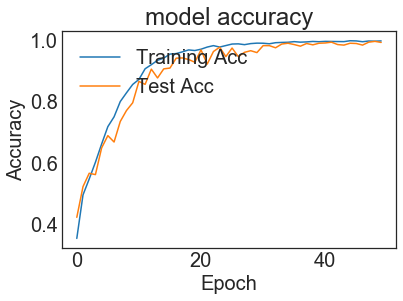

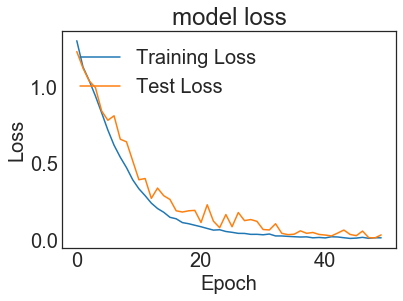

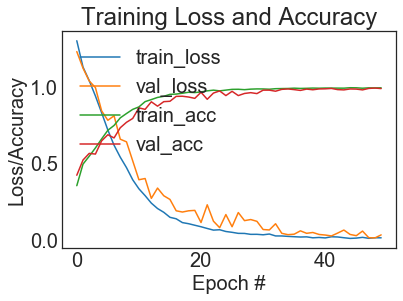

In [41]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [42]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.011192125123158404
Validation Accuracy:  1.0


In [43]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

1792/1792 [==============================] - 22s 12ms/step
No of errors = 856/1792


Confusion Matrix
[[ 92 132 178  46]
 [ 30 211 156  51]
 [ 29  69 345   5]
 [ 70  81   9 288]]


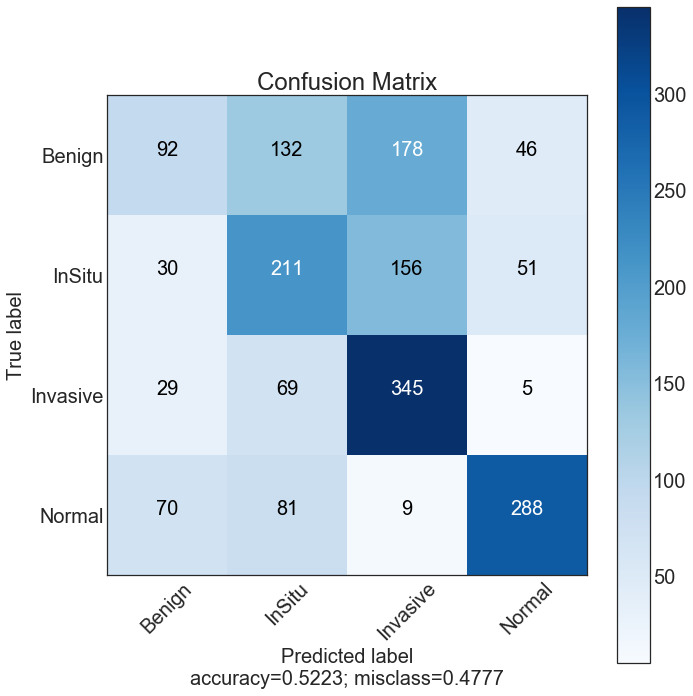

In [44]:


plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')



In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[ 92 132 178  46]
 [ 30 211 156  51]
 [ 29  69 345   5]
 [ 70  81   9 288]]
              precision    recall  f1-score   support

      Normal       0.42      0.21      0.28       448
    Invasive       0.43      0.47      0.45       448
      Benign       0.50      0.77      0.61       448
      InSitu       0.74      0.64      0.69       448

   micro avg       0.52      0.52      0.52      1792
   macro avg       0.52      0.52      0.50      1792
weighted avg       0.52      0.52      0.50      1792



In [46]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Accuracy :  0.16908482142857142
Sensitivity :  0.7540983606557377
Specificity :  0.6151603498542274


_____

In [47]:
filename = test_generator_without_aug.filenames
truth = test_generator_without_aug.classes
label = test_generator_without_aug.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator_without_aug, steps=test_generator_without_aug.samples/test_generator_without_aug.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator_without_aug.samples))

112/112 [==============================] - 2s 15ms/step
No of errors = 48/112


Confusion Matrix
[[ 7  9 10  2]
 [ 1 15  9  3]
 [ 1  3 23  1]
 [ 6  3  0 19]]


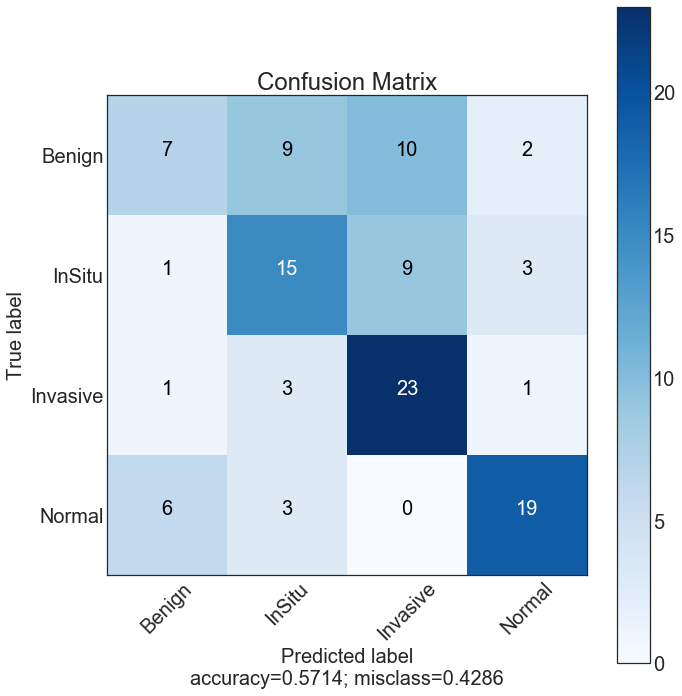

In [48]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator_without_aug.classes

classnames=[]
for classname in test_generator_without_aug.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[ 7  9 10  2]
 [ 1 15  9  3]
 [ 1  3 23  1]
 [ 6  3  0 19]]
              precision    recall  f1-score   support

      Normal       0.47      0.25      0.33        28
    Invasive       0.50      0.54      0.52        28
      Benign       0.55      0.82      0.66        28
      InSitu       0.76      0.68      0.72        28

   micro avg       0.57      0.57      0.57       112
   macro avg       0.57      0.57      0.55       112
weighted avg       0.57      0.57      0.55       112



In [50]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Accuracy :  0.19642857142857142
Sensitivity :  0.875
Specificity :  0.625
